In [1]:
import torch
import pyro
from pyro.ops.indexing import Vindex
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.set_rng_seed(1)

In [2]:
def get_data():
    worker_ids = torch.tensor([1, 1, 1, 2, 3, 4, 5])
    annotations = torch.tensor([
        [1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 4, 2, 2, 3, 1, 1, 1, 2, 1, 2],
        [1, 3, 1, 2, 2, 2, 2, 3, 2, 3, 4, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 2, 2],
        [1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 2, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2],
        [1, 4, 2, 3, 3, 3, 2, 3, 2, 2, 4, 3, 1, 3, 1, 2, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 3, 4, 2, 3, 3, 1, 1, 2, 2, 1, 2],
        [1, 3, 1, 1, 2, 3, 1, 4, 2, 2, 4, 3, 1, 2, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 2, 4, 1, 1, 1, 2, 1, 2],
        [1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 3, 1, 2, 3, 4, 3, 3, 3, 1, 1, 1, 2, 1, 2],
        [1, 4, 2, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2],
    ]).T
    return worker_ids - 1, annotations - 1

In [17]:
class BayesianDawidSkene:
    def __init__(self, num_of_workers, num_of_classes):
        super().__init__()
        self.num_of_workers = num_of_workers
        self.num_of_classes = num_of_classes
    
    def model(self, worker_ids, annotations):
        """
        Input
            worker_ids: (num_of_positions)
            annotations: (num_of_items, num_of_positions)
        """
        num_of_items, num_of_positions = annotations.shape

        one_k = torch.ones(self.num_of_classes)
        
        with pyro.plate("worker", self.num_of_workers, dim=-2):
            with pyro.plate("class", self.num_of_classes):
                beta = pyro.sample("beta", dist.Dirichlet(one_k))
        pi = pyro.sample("pi", dist.Dirichlet(one_k))
        
        with pyro.plate("item", num_of_items, dim=-2):
            c = pyro.sample("c", dist.Categorical(pi))
        
            with pyro.plate("position", num_of_positions):
                pyro.sample("ys", dist.Categorical(beta[worker_ids, c, :]), obs=annotations)

In [54]:
from pyro.infer import MCMC, NUTS

ds = BayesianDawidSkene(5, 4)

worker_ids, annotations = get_data()
nuts_kernel = NUTS(ds.model)

mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=150)
mcmc.run(worker_ids, annotations)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 350/350 [00:32, 10.68it/s, step size=3.73e-01, acc. prob=0.894]


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

In [56]:
df = pd.DataFrame(hmc_samples["pi"])

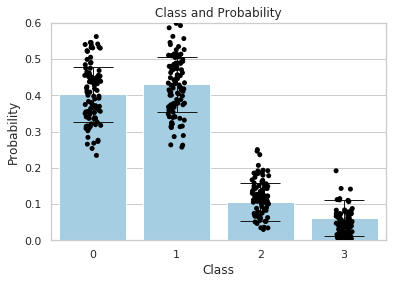

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x_position = np.arange(len(df.columns))
error_bar_set = dict(lw = 1, capthick = 1, capsize = 20)
ax.bar(x_position, df.mean(), yerr=df.std(), tick_label=df.columns, error_kw=error_bar_set)

df_melt = pd.melt(df)
df_melt_little = pd.concat([df_melt[df_melt["variable"] == i].head(100) for i in range(4)])

sns.stripplot(x='variable', y='value', data=df_melt_little, jitter=1, color='black', ax = ax)

ax.set_title('Class and Probability')
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_ylim(0, 0.6)
plt.show()

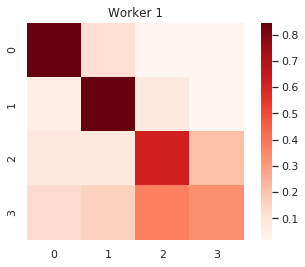

In [58]:
ax = plt.axes()
ax.set_title('Worker 1')
sns.heatmap(hmc_samples["beta"].mean(0)[0], cmap="Reds", square=True, ax=ax);
plt.show()

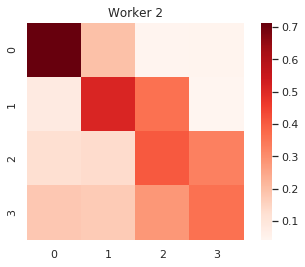

In [59]:
ax = plt.axes()
ax.set_title('Worker 2')
sns.heatmap(hmc_samples["beta"].mean(0)[1], cmap="Reds", square=True, ax=ax);
plt.show()

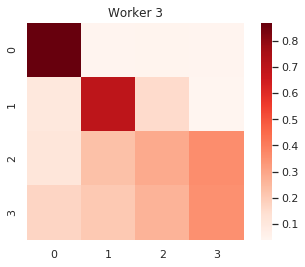

In [60]:
ax = plt.axes()
ax.set_title('Worker 3')
sns.heatmap(hmc_samples["beta"].mean(0)[2], cmap="Reds", square=True, ax=ax);
plt.show()

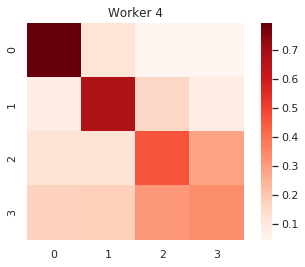

In [61]:
ax = plt.axes()
ax.set_title('Worker 4')
sns.heatmap(hmc_samples["beta"].mean(0)[3], cmap="Reds", square=True, ax=ax);
plt.show()

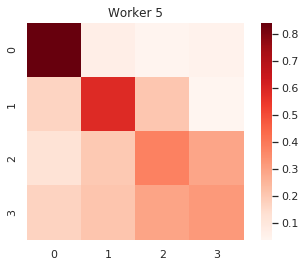

In [62]:
ax = plt.axes()
ax.set_title('Worker 5')
sns.heatmap(hmc_samples["beta"].mean(0)[4], cmap="Reds", square=True, ax=ax);
plt.show()